# Uplift Modeling

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import appropriate statistical modules
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split

In [83]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('marketing_data/data.csv', low_memory=False)

In [84]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB
None


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [85]:
# let's define churn as a customer who has not purchased in the last 6 months
df['churn'] = df.recency.apply(lambda x: 1 if (x > 6) else 0)
df['treatment'] = df.offer.apply(lambda x: 1 if x != 'No Offer' else 0)

In [86]:
df.treatment.describe()

count    64000.000000
mean         0.667094
std          0.471257
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: treatment, dtype: float64

In [87]:
def offer_conversion(df):
    if (df['offer'] != 'No Offer') & (df['conversion'] == 1):
        return 1
    else:
        return 0

def no_offer_conversion(df):
    if (df['offer'] == 'No Offer') & (df['conversion'] == 1):
        return 1
    else:
        return 0

In [88]:
#df['convert_with_offer'] = df.apply(offer_conversion, axis=1)
#df['convert_no_offer'] = df.apply(no_offer_conversion, axis=1)

In [89]:
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
recency,64000.0,5.763734,3.507592,1.00,2.00,6.00,9.0000,12.00
history,64000.0,242.085656,256.158608,29.99,64.66,158.11,325.6575,3345.93
used_discount,64000.0,0.551031,0.497393,0.00,0.00,1.00,1.0000,1.00
used_bogo,64000.0,0.549719,0.497526,0.00,0.00,1.00,1.0000,1.00
is_referral,64000.0,0.502250,0.499999,0.00,0.00,1.00,1.0000,1.00
conversion,64000.0,0.146781,0.353890,0.00,0.00,0.00,0.0000,1.00
churn,64000.0,0.428359,0.494845,0.00,0.00,0.00,1.0000,1.00
treatment,64000.0,0.667094,0.471257,0.00,0.00,1.00,1.0000,1.00


In [90]:
df.describe(exclude='number').T

,count,unique,top,freq
zip_code,64000,3,Surburban,28776
channel,64000,3,Web,28217
offer,64000,3,Buy One Get One,21387


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'recency'),
  Text(0, 1.5, 'history'),
  Text(0, 2.5, 'used_discount'),
  Text(0, 3.5, 'used_bogo'),
  Text(0, 4.5, 'is_referral'),
  Text(0, 5.5, 'conversion'),
  Text(0, 6.5, 'churn'),
  Text(0, 7.5, 'treatment')])

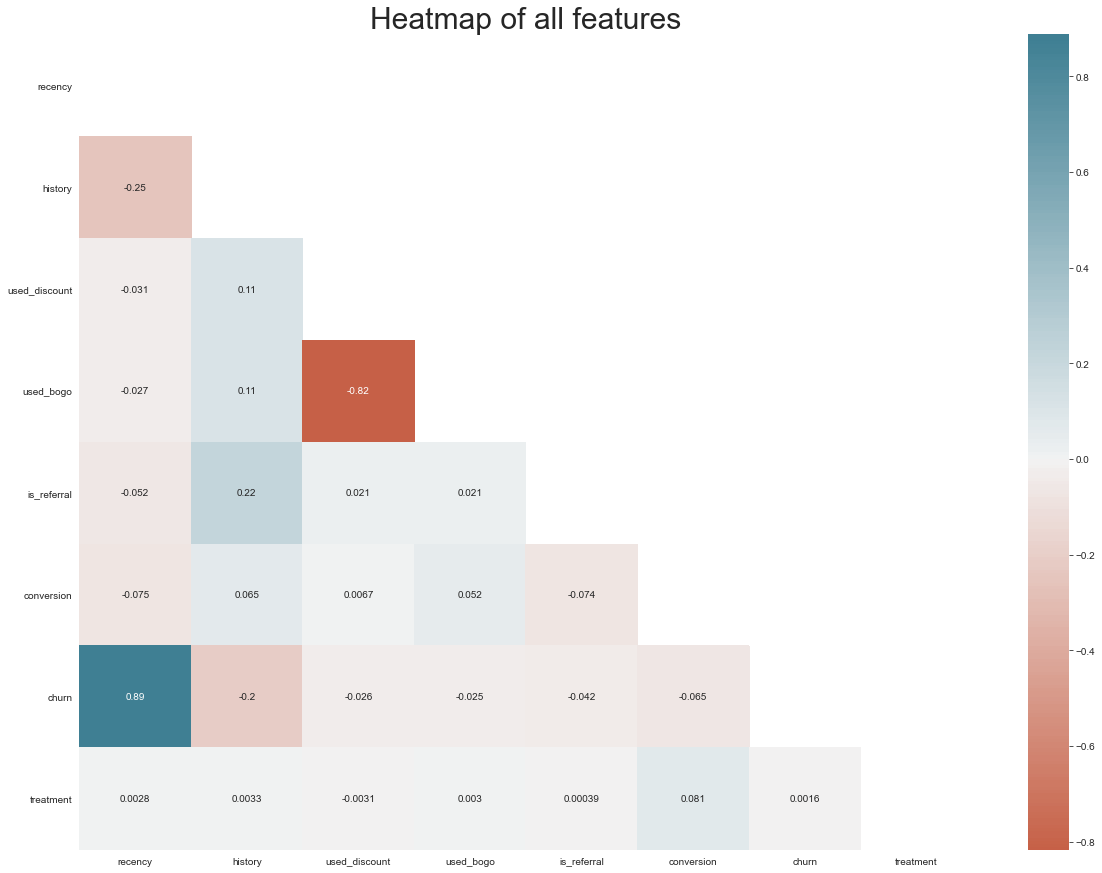

In [91]:
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,15))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, )
plt.title("Heatmap of all features", fontsize = 30)
plt.yticks(rotation=0)

> We can see from the correlation matrix above that referred customers are more likely to have a greater purchase history, customers with greater purchase history are also more likely to use discounts, and churn is negatively correlated with purchase history. All correlations are somewhat expected. 

In [92]:
print('Percentage of customers that convert: {}%'.format(100*round(df['conversion'].mean(),3)))
print('Percentage of treated customers that convert: {}%'.format(100*round(df[df["treatment"]==1]["conversion"].mean(),3)))

Percentage of customers that convert: 14.7%
Percentage of treated customers that convert: 16.7%


In [93]:
con_results_df = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
con_results_df

conversion             
                mean   sum  count
treatment                        
0           0.106167  2262  21306
1           0.167049  7132  42694

> The treatment does seem to be having a positive result on churn,with an average treatment effect (ATE) of about a 6%. Let's test to see if this value is significant or a likely sampling anomoly.

In [94]:
# Quick test reveals that the results are significant
p_value = proportions_ztest(count=con_results_df[('conversion', 'sum')],
                  nobs=con_results_df[('conversion', 'count')])[1]
sig_level = 0.05

if p_value < sig_level:
    print('the p-value is {}, therefore the results are significant'.format(p_value))
else:
    print('results are not statistically significant')

the p-value is 1.7497869967580046e-93, therefore the results are significant


In [95]:
churn_results_df = df.groupby('zip_code').agg({'churn':['mean', 'sum', 'count']})
churn_results_df

churn              
               mean    sum  count
zip_code                         
Rural      0.425494   4069   9563
Surburban  0.433312  12469  28776
Urban      0.423873  10877  25661

In [96]:
churn_results_df = df.groupby('channel').agg({'churn':['mean', 'sum', 'count']})
churn_results_df

churn              
                  mean    sum  count
channel                             
Multichannel  0.308168   2392   7762
Phone         0.444559  12457  28021
Web           0.445334  12566  28217

> Neither of the variables above (zip code, channel) seem to have a significant relationship with churn. It does seem that multichannel customers do have a lower chance of churn. Let's investigate this with a statistical test. 

In [97]:
# define function to output chi-squared test and results
def chi2results(var1, var2, prob):
    observed = pd.crosstab(var1, var2)
    chi_square, p_val, dof, expected = chi2_contingency(observed)
    critical = chi2.ppf(prob, dof)
    
    if abs(chi_square) >= critical:
        result = 'Dependent (reject H0)'
    else:
        result = 'Independent (fail to reject H0)'
    alpha = 1.0 - prob
    
    return chi_square, critical, p_val, dof, alpha, result

In [98]:
# two way table of market segment vs cancellations
observed = pd.crosstab(df.churn, df.channel)
print(observed)

channel  Multichannel  Phone    Web
churn                              
0                5370  15564  15651
1                2392  12457  12566


In [99]:
res = chi2results(df['churn'], df['channel'], prob = 0.95)
print('results of chi squared test: {}'.format(res[5]))

results of chi squared test: Dependent (reject H0)


> There is something about the multichannel customers that improves the likelihood of not churning.

In [100]:
churn_results_df = df.groupby('offer').agg({'churn':['mean', 'sum', 'count']})
churn_results_df

churn             
                     mean   sum  count
offer                                 
Buy One Get One  0.427736  9148  21387
Discount         0.430140  9165  21307
No Offer         0.427204  9102  21306

> The treatment options luckily do not differ significantly in their effect on churn. This could however still be a factor to consider when manipulating variables to maximize the number of persuadable customers. 

## Resampling

Class 0: 21306
Class 1: 42694
Proportion: 2 : 1


(array([1, 0]), [Text(1, 0, '1'), Text(0, 0, '0')])

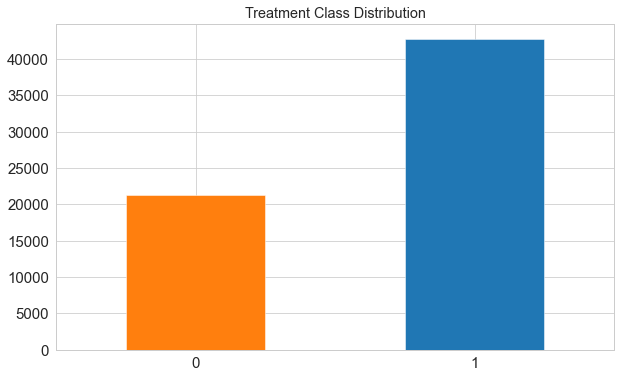

In [101]:
fig = plt.figure(figsize = (10,6))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

> Uplift models assume the treatment and control groups are of equal size, so there is a need to resample here to balance the class. Before resampling however a train, test split will be performed for analyzing results on a realistically distributed test set.

In [102]:
train, test  = train_test_split(df, test_size=0.2, random_state=94, stratify=df['treatment'])

In [103]:
train['treatment'].value_counts()

1    34155
0    17045
Name: treatment, dtype: int64

In [104]:
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [105]:
train = random_under(train, 'treatment')

Class 0: 17045
Class 1: 17045
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

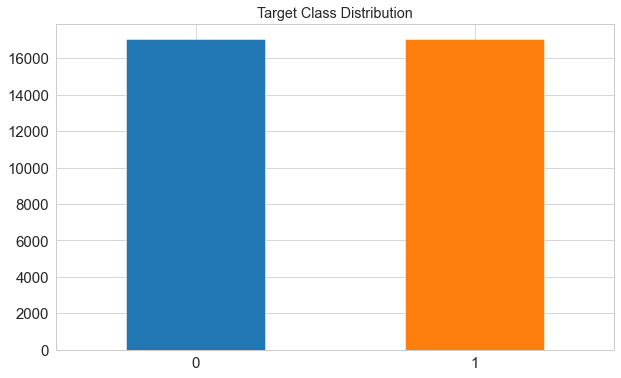

In [106]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['treatment'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

In [108]:
X=train.drop(['churn', 'recency'], axis=1)  # Features
y=train['churn']  # Labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=X['treatment'])

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [109]:
indices_learn = list(X_train.index)
indices_valid = list(X_val.index)
treat_train = X_train.loc[indices_learn, 'treatment']
treat_val =  X_val.loc[indices_valid, 'treatment']

In [110]:
# installation instructions: https://github.com/maks-sh/scikit-uplift
# link to the documentation: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier

cat_features = list(df.select_dtypes(exclude=['float', 'int']).columns.difference(['Churn']))
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

In [111]:
def plot_uplift_preds(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    #check_consistent_length(trmnt_preds, ctrl_preds)
    #check_is_binary(treatment)

    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

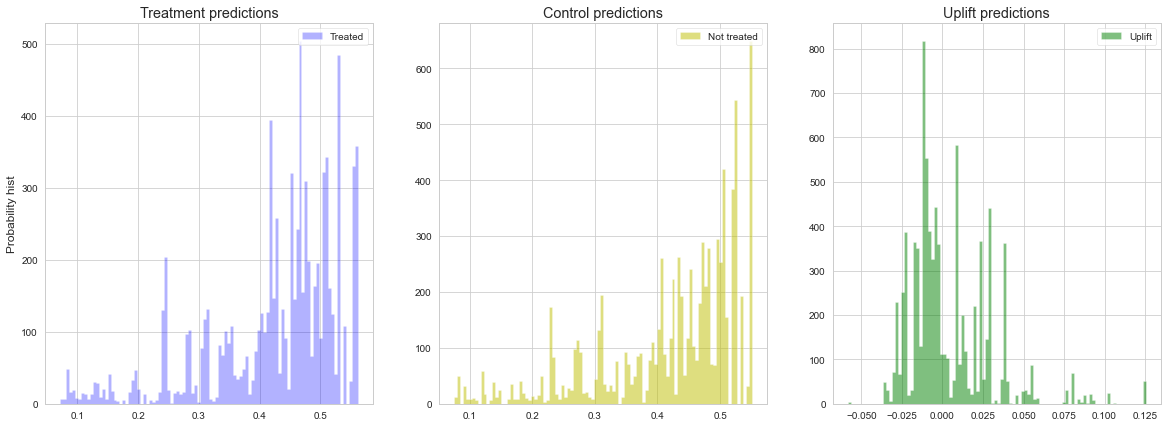

In [112]:
# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [113]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,history,56.090736
1,conversion,19.094999
2,is_referral,7.948155
3,treatment,5.693956
4,used_discount,3.808432
5,used_bogo,2.661332
6,channel,2.564035
7,offer,1.104698
8,zip_code,1.033656


> A customers history not suprisingly is the strongest predictor of churn. Behind this is conversion which reveals that customers that are not churned are more likely to take advantage of the the treatment offer.

In [119]:
X_val.describe()

,history,used_discount,used_bogo,is_referral,conversion,treatment
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,240.453265,0.546521,0.552388,0.506394,0.137158,0.500059
std,253.649198,0.497860,0.497277,0.499988,0.344035,0.500029
min,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,157.760000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,322.965000,1.000000,1.000000,1.000000,0.000000,1.000000
max,2859.630000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


In [120]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.256651
0,SoloModel,0.016432


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0783'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

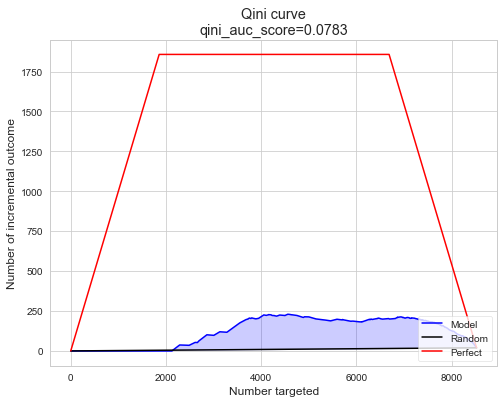

In [121]:
# import vizualisation tools
from sklift.viz import plot_qini_curve

plot_qini_curve(y_true=y_val, uplift=uplift_ct, treatment=treat_val, negative_effect=True)